## Transfer Learning with MobileNetV2
A pre-trained model is a model that's been trained on a large dataset and saved, which allows us to use it to customize our model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 minllion images and 1000 classes.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
MY_SEED = 42

2024-10-28 10:35:33.756182: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 10:35:34.814443: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 10:35:36.929032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 10:35:37.336547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 10:35:37.437145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 10:35:38.109568: I tensorflow/core/platform/cpu_feature_gu

## Load our images

In [2]:
IMAGE_SIZE = (160, 160)
directory = './dataset'
train_dataset = tf.keras.utils.image_dataset_from_directory(directory, 
                                            batch_size=32, 
                                            image_size=IMAGE_SIZE, 
                                            shuffle=True,
                                            seed=MY_SEED, 
                                            subset='training', 
                                            validation_split=0.2)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory, 
                                            batch_size=32, 
                                            image_size=IMAGE_SIZE, 
                                            subset='validation', 
                                            seed=MY_SEED, 
                                            validation_split=0.2, 
                                            shuffle=True)

Found 327 files belonging to 2 classes.
Using 262 files for training.


Found 327 files belonging to 2 classes.
Using 65 files for validation.


## Explore the data
Each sub-directory representes a class.

In [3]:
class_names = train_dataset.class_names
print(class_names)

['alpaca', 'not alpaca']


In [4]:
print('Number of training batches:', len(train_dataset))
print('Number of training batches:', len(validation_dataset))

for data, labels in train_dataset.take(1): 
    print('Shape of the first batch', data.shape)
    print('labels', labels)


Number of training batches: 9
Number of training batches: 3
Shape of the first batch (32, 160, 160, 3)
labels tf.Tensor([0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0], shape=(32,), dtype=int32)


2024-10-28 10:35:52.797982: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


There are 32 images in each batch, each image has shape (160, 160, 3).

The labels contains 32 true labels for images in a batch

Now let's take a look at some of the images from the training set: 

2024-10-28 10:35:53.482489: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


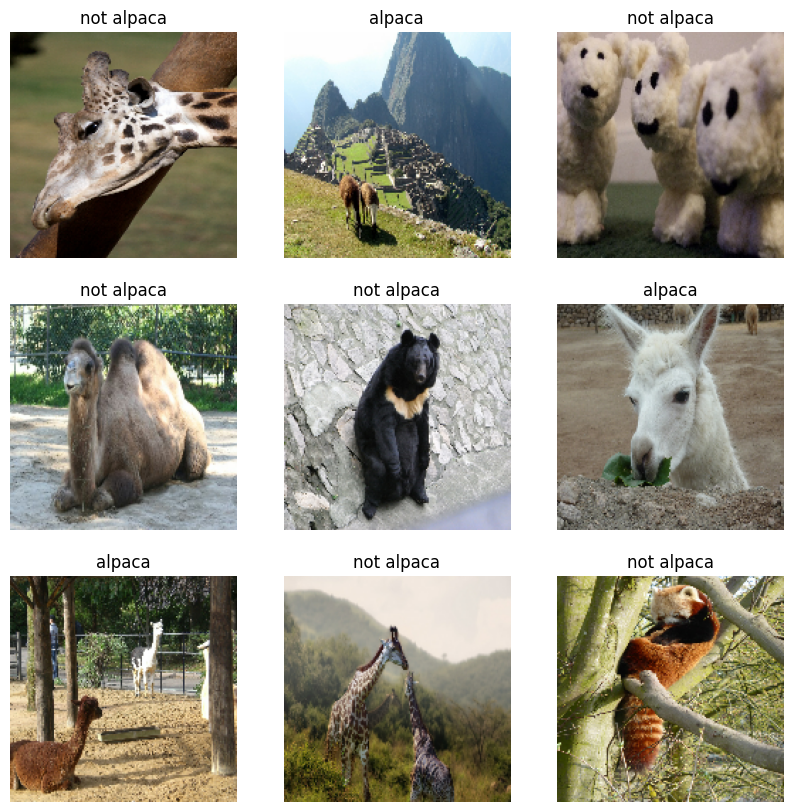

In [5]:
plt.figure(figsize=(10, 10))
for data, labels in train_dataset.take(1): 
    # Plot 9 images
    for i in range(9): 
        ax = plt.subplot(3, 3, i+1)
        ax.set_title(class_names[labels[i]])
        ax.imshow(tf.cast(data[i], tf.int16) )
        ax.axis('off')
        

## Preprocess and Augment Training Data
Using `.prefetch()` prevents memory bottleneck that can occur when reading from the disk. It sets aside some data and keeps it ready for when it's needed. Because the iteration is streaming, the data doesn't need to fit into memory

You can set the number of elements to prefetch manually, or you can use `tf.data.AUTOTUNE` to choose the parameters automatically. `AUTOTUNE` prompts `tf.data` to tune the value dynamically at runtime, by tracking the time spent in each operation and feeding those times into optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmenter
To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kind of data augmentations, with built-in, customizable preprocessing layers.

In [7]:
def data_augmenter(): 
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    return data_augmentation

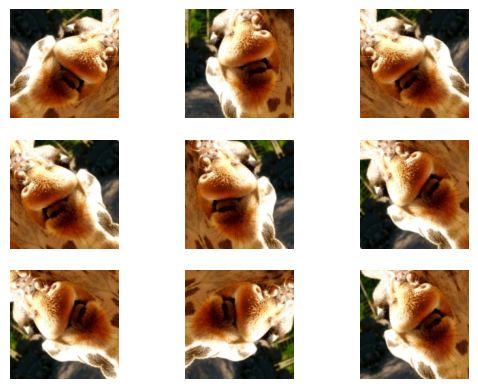

In [8]:
data_augmentation = data_augmenter()
for image, labels in train_dataset.take(1): 
    first_image = image[0]
    for i in range(9): 
        # Third paramenter is index which starts from 1
        ax = plt.subplot(3, 3, i + 1)
        
        # Expand input from (160, 160, 3) to (1, 160, 160, 3)
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0))
        
        ax.imshow(augmented_image[0]/255)
        ax.axis('off')

Next, you'll apply your first tool from the `MobileNet` application in Tensorflow, to normalize our input. Since we're using a pre-trained model that was trained on the normalization values [-1, 1], it's best practice to reuse that standard with `tf.keras.applications.mobilenet_v2.preprocess_input`

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Using MobileNetV2 for Transfer Learning
MobileNetV2 was trained on ImageNet dataset and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics: 
- Depthwise separable convolutions
- Thin input and output bottlenecks between layers
- Shortcut connections between bottleneck layers

## Inside a MobileNetV2 Convolutional Building Block
MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 
  1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.
  2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is pointwise convolution

Let's try to train the the base model using `all the layers` from the pre-trained model.

Similarly to how we reused the pre-trained normalization values MobileNetV2 was trained on, we'll also load the pre-trained weights from `ImageNet` by specifying `weights='imagenet'`

In [10]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=True, 
                                               weights='imagenet')

In [11]:
IMG_SHAPE

(160, 160, 3)

Run the following code to see the summary of the model's layers, the shape of their outputs and the total number of paramenters, trainable and non-trainable.

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Note the last 2 layers. They are also called the top layers, and they are responsible for the classification in the model.

In [13]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers-2].name)
print(base_model.layers[nb_layers-1].name)

global_average_pooling2d
predictions


Try to predict images from the pre-trained model without any our touch.

In [14]:
image_batch, label_batch = next(iter(train_dataset)) 
feature_batch = base_model(image_batch)
print(feature_batch)

2024-10-28 10:37:38.051258: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-10-28 10:37:39.219463: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-10-28 10:37:39.249044: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-10-28 10:37:39.283106: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-10-28 10:37:39.298749: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.


tf.Tensor(
[[9.82834172e-05 1.91449374e-03 4.45847945e-05 ... 2.68423901e-04
  3.60773341e-03 9.50926769e-05]
 [1.77309688e-04 1.21620507e-03 7.90351696e-05 ... 2.29064201e-04
  2.23253085e-03 1.12106296e-04]
 [2.80333683e-04 4.35908674e-04 1.42472709e-04 ... 3.02321987e-05
  1.73051521e-04 3.00486834e-04]
 ...
 [6.30167488e-05 2.42866547e-04 3.40909697e-04 ... 1.24692277e-04
  4.27499726e-05 7.16354843e-05]
 [1.85175246e-04 7.93082174e-04 5.88202056e-05 ... 2.69014126e-05
  5.79379484e-05 1.78723392e-04]
 [7.28294981e-05 1.59995179e-04 2.24708874e-05 ... 3.38411592e-05
  5.24880714e-04 4.77976100e-05]], shape=(32, 1000), dtype=float32)


Now decode the predictions made by the model. Ealier, when we printed the shape of the model, it would have returned (32, 1000). The number 32 refer to the batch size and 1000 refers to 1000 classes the model was pre-trained on. The predictions returned by the base model follow this format: 

First the class number, then a human-readable label, and last the probability of the image belonging to that class. We'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [15]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)
decoded_pred = tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)
decoded_pred

[[('n02454379', 'armadillo', 0.892808),
  ('n02172182', 'dung_beetle', 0.024268957)],
 [('n02437312', 'Arabian_camel', 0.2954119),
  ('n02134084', 'ice_bear', 0.043125372)],
 [('n01616318', 'vulture', 0.07522409), ('n02130308', 'cheetah', 0.06773587)],
 [('n02437616', 'llama', 0.9813888),
  ('n02437312', 'Arabian_camel', 0.00090887095)],
 [('n02483362', 'gibbon', 0.1656338),
  ('n02509815', 'lesser_panda', 0.10041605)],
 [('n02133161', 'American_black_bear', 0.87991196),
  ('n02132136', 'brown_bear', 0.019821651)],
 [('n01518878', 'ostrich', 0.957881), ('n02018795', 'bustard', 0.0029069397)],
 [('n02437616', 'llama', 0.78147125),
  ('n02098286', 'West_Highland_white_terrier', 0.04396367)],
 [('n02410509', 'bison', 0.4543138), ('n02132136', 'brown_bear', 0.45169234)],
 [('n02133161', 'American_black_bear', 0.69108707),
  ('n02132136', 'brown_bear', 0.08774342)],
 [('n01518878', 'ostrich', 0.87967324),
  ('n02018795', 'bustard', 0.0077298484)],
 [('n02437616', 'llama', 0.4719327), ('n024

## Layer Freezing with Functional API
In this next sections, we'll see how we can use the pre-trained model and modify the classifier task so that it's able to recognize alpacas. We can achieve this in three steps: 
1. Delete the top layer (the classification layer)
  - Set `include_top` in `base_model` as False
2. Add a new classifier layer
  - Train only one layer by freezing the rest of the network
  - A single neuron is enough to solve a binary classification problem
3. Freeze the base model and train the newly-created classifier layer
  - Set `base_model.trainable=False` to avoid changing the weights and train **only** the new layer
  - Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [16]:
def alpaca_model(image_size=IMAGE_SIZE, data_augmentation=data_augmenter()): 
    input_shape = image_size + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, 
                                                   include_top=False, 
                                                   weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)
    return model
    

Create new model by using data_augmentation function defined earlier.

In [17]:
model2 = alpaca_model(IMAGE_SIZE, data_augmentation)

In [18]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
               metrics=['accuracy'])

In [20]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 606ms/step - accuracy: 0.5541 - loss: 0.7475 - val_accuracy: 0.5846 - val_loss: 0.6541
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 513ms/step - accuracy: 0.6500 - loss: 0.5943 - val_accuracy: 0.7385 - val_loss: 0.5122
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - accuracy: 0.7146 - loss: 0.4977 - val_accuracy: 0.7538 - val_loss: 0.4374
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - accuracy: 0.6922 - loss: 0.5241 - val_accuracy: 0.7538 - val_loss: 0.4115
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.7499 - loss: 0.4345 - val_accuracy: 0.8462 - val_loss: 0.3418


In [21]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [22]:
print(acc)

[0.5648854970932007, 0.6832060813903809, 0.7213740348815918, 0.7175572514533997, 0.7595419883728027]


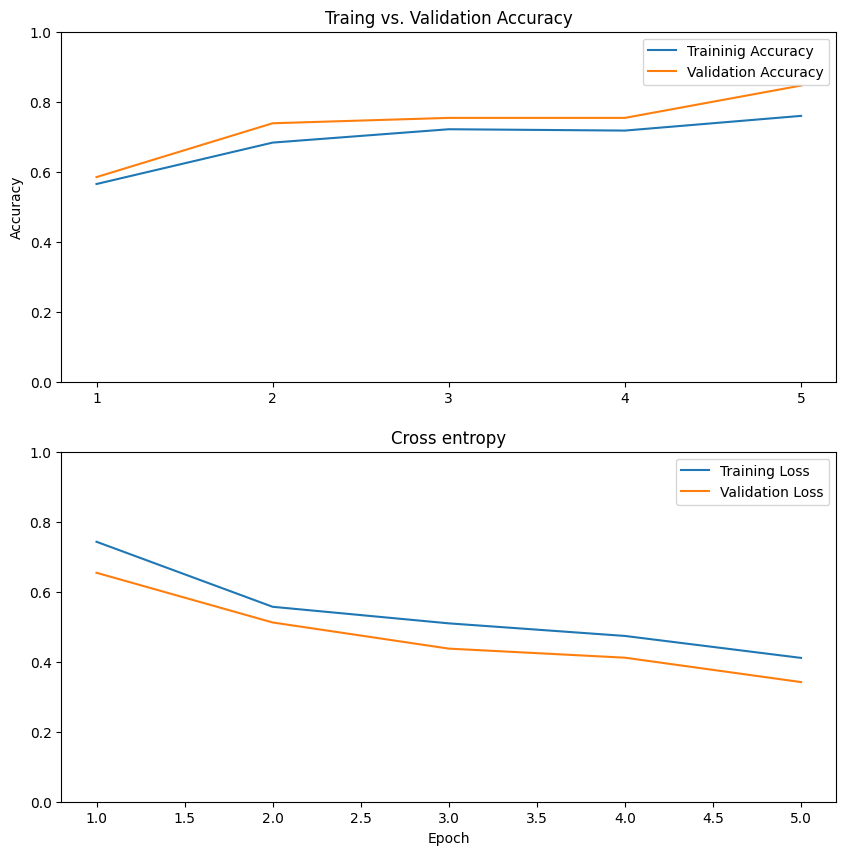

In [23]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)

ax.plot(np.arange(1, len(acc) +1), acc, label='Traininig Accuracy')
ax.plot(np.arange(1, len(acc) +1), val_acc, label='Validation Accuracy')
ax.legend()
ax.set_ylim([0, 1])
ax.set_ylabel('Accuracy')
ax.set_title('Traing vs. Validation Accuracy')
ax.set_xticks(np.arange(1, len(acc) +1))

ax = plt.subplot(2, 1, 2)
ax.plot(np.arange(1, len(acc) +1), loss, label='Training Loss')
ax.plot(np.arange(1, len(acc) +1), val_loss, label='Validation Loss')
ax.set_ylim([0, 1.0])
ax.set_title('Cross entropy')
ax.legend()
ax.set_xlabel('Epoch')
plt.show()

The results are ok, but could be better. Next, try some `fine-tunning`

In [24]:
model2.layers

[<InputLayer name=input_layer_3, built=True>,
 <Sequential name=sequential, built=True>,
 <Functional name=mobilenetv2_1.00_160, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_1, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense, built=True>]

In [25]:
def print_layer_names(model, indent=0):
    # Iterate through all layers of the model
    for layer in model.layers:
        print("  " * indent + layer.name)
        # If the layer is a nested model (such as a Sequential or Functional model), recurse into it
        if isinstance(layer, tf.keras.Model):
            print_layer_names(layer, indent + 1)

# Assuming `model2` is your model instance
print_layer_names(model2)

input_layer_3
sequential
  random_flip
  random_rotation
mobilenetv2_1.00_160
  input_layer_2
  Conv1
  bn_Conv1
  Conv1_relu
  expanded_conv_depthwise
  expanded_conv_depthwise_BN
  expanded_conv_depthwise_relu
  expanded_conv_project
  expanded_conv_project_BN
  block_1_expand
  block_1_expand_BN
  block_1_expand_relu
  block_1_pad
  block_1_depthwise
  block_1_depthwise_BN
  block_1_depthwise_relu
  block_1_project
  block_1_project_BN
  block_2_expand
  block_2_expand_BN
  block_2_expand_relu
  block_2_depthwise
  block_2_depthwise_BN
  block_2_depthwise_relu
  block_2_project
  block_2_project_BN
  block_2_add
  block_3_expand
  block_3_expand_BN
  block_3_expand_relu
  block_3_pad
  block_3_depthwise
  block_3_depthwise_BN
  block_3_depthwise_relu
  block_3_project
  block_3_project_BN
  block_4_expand
  block_4_expand_BN
  block_4_expand_relu
  block_4_depthwise
  block_4_depthwise_BN
  block_4_depthwise_relu
  block_4_project
  block_4_project_BN
  block_4_add
  block_5_expand


## Fine-tunning the Model
We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take a smaller step to adapt it a little more closely to the new data. In transfer learning, the way we achive this is by unfreezing the layers at the end of the network, and then re-training our model on the final layers with a very low learning rate. Adapting our leanring rate to go over these layers in smaller steps can yiel more find details - and higher accuracy.

To achive this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozon.

In [26]:
import tensorflow as tf

# Get the first 4 layers of model2
base_model = model2.layers[0:4]

# Function to set all layers as trainable
def set_trainable_and_count_layers(model):
    total_layers = 0
    for layer in model:
        # Check if the layer is a nested model
        if isinstance(layer, tf.keras.Model):
            for sublayer in layer.layers:
                sublayer.trainable = True
                total_layers += 1
        else:
            layer.trainable = True
            total_layers += 1
    return total_layers

# Get the total number of layers and set them as trainable
total_layers = set_trainable_and_count_layers(base_model)

print(f"Total number of layers in the selected base model: {total_layers}")


Total number of layers in the selected base model: 158


In [27]:
import tensorflow as tf

# Get the MobileNet model layer from model2
mobilenet = model2.layers[2]

# Define the layer index from which we want to start fine-tuning
fine_tune_at = 20

# Freeze all layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

# Make layers from `fine_tune_at` onwards trainable
for layer in mobilenet.layers[fine_tune_at:]:
    layer.trainable = True

# Print the results
total_layers = len(mobilenet.layers)
print(f"Total number of layers in MobileNet: {total_layers}")
print(f"Number of layers frozen: {fine_tune_at}")
print(f"Number of layers trainable: {total_layers - fine_tune_at}")


Total number of layers in MobileNet: 154
Number of layers frozen: 20
Number of layers trainable: 134


In [28]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
metrics = ['accuracy']
model2.compile(optimizer=optimizer, 
               loss=loss_function, 
               metrics=metrics)

In [29]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,214,449 (8.45 MB)

 Non-trainable params: 44,816 (175.06 KB)

In [30]:
model2.layers[2].compile(optimizer=optimizer)

In [31]:
model2.layers[2].summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [32]:

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs
history_tune = model2.fit(train_dataset, epochs=total_epochs,
                          initial_epoch=history.epoch[-1], 
                        validation_data=validation_dataset)

Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7146 - loss: 0.5828 - val_accuracy: 0.9077 - val_loss: 0.2076
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8982 - loss: 0.2934 - val_accuracy: 0.9231 - val_loss: 0.1549
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9289 - loss: 0.2498 - val_accuracy: 0.9231 - val_loss: 0.1244
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9341 - loss: 0.1729 - val_accuracy: 0.9692 - val_loss: 0.1052
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1000ms/step - accuracy: 0.9451 - loss: 0.1360 - val_accuracy: 0.9692 - val_loss: 0.0994
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9534 - loss: 0.1136 - val_accuracy: 0.9846 - val_loss: 0.0804


In [33]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,688,165 (25.51 MB)

 Trainable params: 2,214,449 (8.45 MB)

 Non-trainable params: 44,816 (175.06 KB)

 Optimizer params: 4,428,900 (16.89 MB)

In [34]:
history.epoch

[0, 1, 2, 3, 4]

In [35]:
acc += history_tune.history['accuracy']
val_acc += history_tune.history['val_accuracy']

loss += history_tune.history['loss']
val_loss += history_tune.history['val_loss']

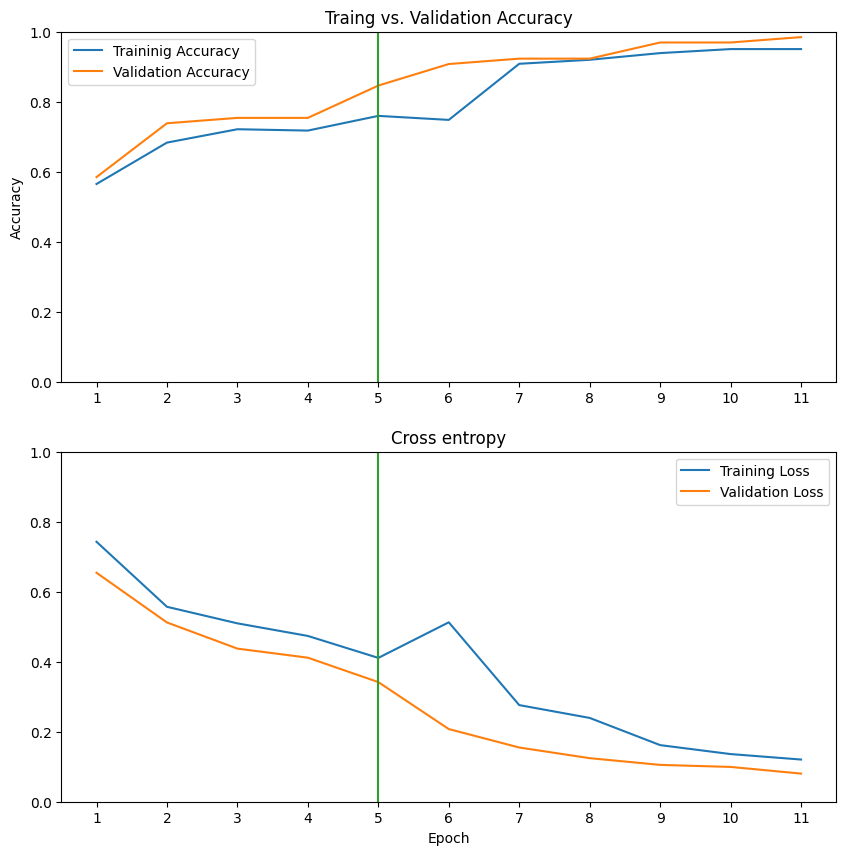

In [36]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Ax 1
ax.plot(np.arange(1, len(acc) +1), acc, label='Traininig Accuracy')
ax.plot(np.arange(1, len(acc) +1), val_acc, label='Validation Accuracy')
ax.legend()
ax.set_ylim([0, 1])
ax.plot([history.epoch[-1] + 1, history.epoch[-1] + 1], (ax.get_ylim()))
ax.set_ylabel('Accuracy')
ax.set_title('Traing vs. Validation Accuracy')
ax.set_xticks(np.arange(1, len(acc) +1))

# Ax 2
ax = plt.subplot(2, 1, 2)
ax.plot(np.arange(1, len(acc) +1), loss, label='Training Loss')
ax.plot(np.arange(1, len(acc) +1), val_loss, label='Validation Loss')
ax.set_ylim([0, 1.0])
ax.plot([history.epoch[-1] + 1, history.epoch[-1] + 1], (ax.get_ylim()))
ax.set_title('Cross entropy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(1, len(acc) +1))
plt.show()